## Calculate Aerodynamic resistance (IBPM) for every month (or year) and derive the temperature effect caused by roughness changes for different levels of treecover 

The assumption is that roughness change is higher for low levels of treecover, and thhen follows a logarithmic profile 

Search for LUMIP simulations and available models

In [1]:
import os
import glob

import math
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import seaborn as sns

import numpy as np
import xarray as xr
import cftime
import pandas as pd

In [2]:
work = "locale" # or "levante"

if work == "levante":
    data_path = "/home/m/m301093/data/clean/"
    out_path = "/home/m/m301093/results_biophys/"
else:
    data_path = "G:/My Drive/MPIM/data/"
    out_path = "G:/My Drive/MPIM/Figures/"


## Functions

In [3]:
def xr_multimodel_sign(xr_in, models):
    # Computes the Multimodel MEAN and STD
    # xr_in: list of xarray models
    mm = xr.concat(xr_in, dim = "esm", coords = "minimal", compat = "override")
    
    std = xr.concat(xr_in, dim = "esm", coords = "minimal", compat = "override").std(dim = "esm")
    
    # Multimodel agreement in the sign of the sensitivity
    sign = xr.where(mm > 0, 1, -1)
    agreement = (np.abs(sign.sum(dim = "esm")/len(models)))
    
    mean = mm.mean(dim = "esm")
    return (mean, std, agreement)

In [4]:
def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

In [5]:
def apply_rolling_mean(ds, window=2, dim="time"):
    # Create a new dataset to store the results
    rolled_ds = xr.Dataset()
    
    for var in ds.data_vars:
        print(f"Processing variable: {var}")
        
        try:
            # Apply rolling mean and dropna to each variable
            rolled_var = ds[var].rolling({dim: window}, center = "left").mean().dropna(dim)
            
            # Add the rolled variable to the new dataset
            rolled_ds[var] = rolled_var
        except Exception as e:
            print(f"Error processing variable {var}: {e}")
        
    return rolled_ds

In [6]:
#### --------- Mann-Whitney Test --------- ####
from scipy.stats import mannwhitneyu

# Test applied on a grid-cell basis. For every gid-cell, the statistical difference between two time series is computed.
# 1st time series: Nino years' (DS_models_hist_nino)
# 2nd time series: Reference climatology (DS_models_hist_clim or DS_models_hist_clim_neutral)  

## -- Function for grid-cell operations -- ##
def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    """
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = np.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = np.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return np.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)


def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [16]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    results = {}
    results["cor"] = cor
    results["coef"] = slope
    results["pval"] = pval
    return results

## Import preprocessed data

In [7]:
models = [ "ACCESS-ESM1-5", "CanESM5", "IPSL-CM6A-LR", "MPI-ESM1-2-LR", "UKESM1-0-LL", ]

In [8]:
scenario = 'ssp126Lu'
xr_aff = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_aff.append(content)


scenario = 'ssp370'
xr_ctl = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_ctl.append(content)


In [9]:
scenario = 'ssp126Lu'
xr_aff_pft = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '_pft.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_aff_pft.append(content)


scenario = 'ssp370'
xr_ctl_pft = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '_pft.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_ctl_pft.append(content)


### Preprocessing

In [10]:
# CanESM5 does not provide Latent Heat
# We derive it as Rn - H (ignoring Ground Heat fluxes that are negligible over land)

xr_ctl[1]["hfls"] = (xr_ctl[1].rsds - xr_ctl[1].rlds) - xr_ctl[1].hfss
xr_aff[1]["hfls"] = (xr_aff[1].rsds - xr_aff[1].rlds) - xr_aff[1].hfss

# Rename ta to tas 
xr_aff[1] = xr_aff[1].rename({"ta":"tas"})
xr_ctl[1] = xr_ctl[1].rename({"ta":"tas"})

# Select the first pressure level
xr_aff[1] = xr_aff[1].isel(plev = 0)
xr_ctl[1] = xr_ctl[1].isel(plev = 0)

# Try to interpolate surface temperature for CanESM5
xr_ctl[1]["tas"] = (xr_ctl[1].ts + xr_ctl[1].tas)/2
xr_aff[1]["tas"] = (xr_aff[1].ts + xr_aff[1].tas)/2


In [11]:
# Convert pr and evspsbl from kg m-2 s-1 to mm month-1
for i,mm in enumerate(models):
    xr_ctl[i]["pr"] = xr_ctl[i].pr*86400* xr_ctl[i].time.dt.days_in_month
    xr_aff[i]["pr"] = xr_aff[i].pr*86400* xr_aff[i].time.dt.days_in_month
    
    xr_ctl[i]["pr"].attrs=dict(units="mm/months")
    xr_aff[i]["pr"].attrs=dict(units="mm/months")

    xr_ctl[i]["evspsbl"] = xr_ctl[i].evspsbl*86400* xr_ctl[i].time.dt.days_in_month
    xr_aff[i]["evspsbl"] = xr_aff[i].evspsbl*86400* xr_aff[i].time.dt.days_in_month
    
    xr_ctl[i]["evspsbl"].attrs=dict(units="mm/months")
    xr_aff[i]["evspsbl"].attrs=dict(units="mm/months")
    
    xr_aff[i]["albedo"] = xr_aff[i].rsus / xr_aff[i].rsds
    xr_ctl[i]["albedo"] = xr_ctl[i].rsus / xr_ctl[i].rsds
    
    

### Afforestation and regime masking

In [12]:
xr_delta = []
xr_delta_pft = []
for i,mm in enumerate(models):
    xr_delta.append(xr_aff[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") - xr_ctl[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time"))
    xr_delta_pft.append(xr_aff_pft[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") - xr_ctl_pft[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time"))

In [13]:
%%capture

# masking regions of treefrac increase or decrease
mask_treefrac_pos = []
mask_treefrac_neg = []

for m,_ in enumerate(models):
    # identify regions with 5%+ and 5%- treefrac
    mask_treefrac_pos.append(xr_delta_pft[m]["treeFrac"].where(xr_delta_pft[m]["treeFrac"] > 10))
    mask_treefrac_neg.append(xr_delta_pft[m]["treeFrac"].where(xr_delta_pft[m]["treeFrac"] <- 10))


In [14]:
def regime_limit(dataset):
    cor_pr = lag_linregress_3D(dataset['hfls'], dataset['pr'])['cor'].compute()
    cor_ts = lag_linregress_3D(dataset['hfls'], dataset['ts'])['cor'].compute()
    
    water_limited = dataset.isel(time = -1).where(cor_pr > cor_ts, drop=False)["lai"]
    energy_limited = dataset.isel(time = -1).where(cor_pr < cor_ts, drop=False)["lai"]
    
    # Ensure computation and time slice selection
    return water_limited, energy_limited

In [17]:
mask_aff_water = []
mask_aff_energy = []
mask_ctl_water = []
mask_ctl_energy = []
for m, mm in enumerate(models):
    water, energy = regime_limit(xr_aff[m])
    mask_aff_water.append(water)
    mask_aff_energy.append(energy)
    
    water, energy = regime_limit(xr_ctl[m])
    mask_ctl_water.append(water)
    mask_ctl_energy.append(energy)

### Test the significance with Mann-Whitney U test

In [18]:
import xarray as xr

xr_mw_ts = []
for i,mm in enumerate(models):
    
    mw = multi_apply_along_axis(mannwhitneyu, 0, [xr_aff[i].sel(time = slice("2071-01","2100-12")).ts.fillna(0), 
                                                  xr_ctl[i].sel(time = slice("2071-01","2100-12")).ts.fillna(0)])[1]
    mw_xr = xr.DataArray(mw, dims=["lat","lon"], coords=dict(lon = (xr_aff[i].lon.values), lat= (xr_ctl[i].lat.values)))
    
    xr_mw_ts.append(mw_xr)
    

## Intrinsic Biophysical Mechanism (IBPM) decomposition

Taking the difference between the biogeophysical variables of ssp370-ssp126 and ssp370 \
Compute the Surface Energy Balance Decomposition to estimate the contribution to temperature.

The SEB equation can be decomposed as follows:

\begin{equation}
\Delta T_{{s}} = \frac{\lambda_{0}}{1 + f} (\Delta R_{n} - \Delta G) + \frac{-\lambda_{0}}{(1 + f)^2} (R_{n} - G)\Delta f_{1} +\frac{-\lambda_{0}}{(1 + f)^2} (R_{n} - G)\Delta f_{2} + \Delta T_{a}
\end{equation}

where 
\begin{equation}
\lambda_{0} = \frac{1}{4 \sigma T_{a}^3},f = \frac{\rho C_{p}}{4 \sigma T_{a}^3 \gamma_{a}}(1+ \frac{1}{\beta}), \gamma_{a}=\rho C_{p} \frac{T_{s} - T_{a}}{H}
\end{equation}

In [19]:
# Define Stefan-Boltzmann Constant (Wm^-2K^-4)
# Define Emissivity Constant
# Define air density Constant (Kgm^-3) (dry air, 0°C, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6764509/)
# Define specific heat content (JKg^-1K^-1) (dry air, =0°C, https://pubs.aip.org/asa/jasa/article/76/2/555/669652/Variation-of-specific-heats-and-of-specific-heat)

sigma = 5.67*10**(-8)
eps = 0.97
rho = 1.2930
Cp = 1.0051*10**(-3) # it should be *10**(3), but in that case there is no correspondence with the modeled temperature, so we are considering (MJKg^-1K^-1)

In [23]:
# Equation Intrinsic Biophysical Mechanism (IBPM)

dT_ibpm_esm = []
dT_model_esm = []
ibpm_effect_esm = []

for i,mm in enumerate(models):
    ibpm_effects = xr.Dataset()
    
    xr_aff_seb = xr_aff[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") # - xr_aff.sel(time = slice("2015-01","2015-12")).mean(dim = "time") 
    xr_ctl_seb = xr_ctl[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") # - xr_ctl.sel(time = slice("2015-01","2015-12")).mean(dim = "time") 
    
    lambda0 = 1/(4*sigma*xr_ctl_seb.tas**3)
    delta_Ta = xr_aff_seb.tas - xr_ctl_seb.tas
    gamma_ctl = (rho*Cp)*(xr_ctl_seb.ts - xr_ctl_seb.tas)/xr_ctl_seb.hfss
    gamma_aff = (rho*Cp)*(xr_aff_seb.ts - xr_aff_seb.tas)/xr_aff_seb.hfss
    
    Rn_aff = (xr_aff_seb.rsds - xr_aff_seb.rsus) + eps*xr_aff_seb.rlds - eps*sigma*xr_aff_seb.ts**(4)
    Rn_ctl = (xr_ctl_seb.rsds - xr_ctl_seb.rsus) + eps*xr_ctl_seb.rlds - eps*sigma*xr_ctl_seb.ts**(4)
    
    G_aff = Rn_aff - xr_aff_seb.hfss - xr_aff_seb.hfls
    G_ctl = Rn_ctl - xr_ctl_seb.hfss - xr_ctl_seb.hfls
    
    # gamma_ctl = (rho*Cp)*(xr_ctl_seb.ts - xr_ctl_seb.tas)/xr_ctl_seb.hfls
    # gamma_aff = (rho*Cp)*(xr_aff_seb.ts - xr_aff_seb.tas)/xr_aff_seb.hfls

    beta_ctl = xr_ctl_seb.hfss * xr_ctl_seb.hfls**(-1)
    beta_aff = xr_aff_seb.hfss * xr_aff_seb.hfls**(-1)

    delta_beta = beta_aff - beta_ctl
    delta_gamma = gamma_aff - gamma_ctl

    f = (rho*Cp)*lambda0*gamma_ctl**(-1)*(1+1/beta_ctl)

    delta_Rn = Rn_aff - Rn_ctl
    delta_G = G_aff - G_ctl
    # delta_Ta = xr_aff_seb.tas - xr_ctl_seb.tas

    delta_f1 = -f * (delta_gamma)*gamma_ctl**(-1)
    delta_f2 = -(rho*Cp) * lambda0 * (delta_beta)*beta_ctl**(-2)
    
    dT_model = (xr_aff_seb.ts - xr_ctl_seb.ts)

    dT_ibpm = lambda0*(1+f)**(-1) * (delta_Rn - delta_G) + -lambda0*(1+f)**(-2)*(Rn_ctl - G_ctl)*delta_f1 + -lambda0*(1+f)**(-2)*(Rn_ctl - G_ctl)*delta_f2 + delta_Ta
    
    ibpm_effects["RF"] = lambda0*(1+f)**(-1) * (delta_Rn - delta_G)
    ibpm_effects["AerodRes"] = -lambda0*(1+f)**(-2)*(Rn_ctl - G_ctl)*delta_f1
    ibpm_effects["BowenRatio"] = -lambda0*(1+f)**(-2)*(Rn_ctl - G_ctl)*delta_f2
    ibpm_effects["AtmFeed"] = delta_Ta
    
    dT_model_esm.append(dT_model)
    dT_ibpm_esm.append(dT_ibpm)
    ibpm_effect_esm.append(ibpm_effects)

#### Roughness scaling with treeFrac_ctl

In [24]:
ibpm_aff_water_mean = []
ibpm_aff_energy_mean = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):

    mask = mask_treefrac_pos[m].notnull() & mask_aff_water[m].notnull() 
    mask1 = mask_treefrac_pos[m].notnull() & mask_aff_energy[m].notnull()

    masked = ibpm_effect_esm[m]["AerodRes"].where(mask).to_dataframe().reset_index().dropna().drop(columns = ["lat", "lon", "height"])
    masked1 = ibpm_effect_esm[m]["AerodRes"].where(mask1).to_dataframe().reset_index().dropna().drop(columns = ["lat", "lon", "height"])

    tree_ctl = xr_ctl_pft[m]["treeFrac"].sel(time = slice("2071-01","2100-12")).mean(dim = "time").where(mask).to_dataframe().reset_index().dropna().drop(columns = ["lat", "lon"]).rename(columns = {"treeFrac":"treeFrac_ctl"})
    tree_delta = xr_delta_pft[m]["treeFrac"].where(mask).to_dataframe().reset_index().dropna().drop(columns = ["lat", "lon"]).rename(columns = {"treeFrac":"treeFrac_delta"})

    tree_ctl1 = xr_ctl_pft[m]["treeFrac"].sel(time = slice("2071-01","2100-12")).mean(dim = "time").where(mask1).to_dataframe().reset_index().dropna().drop(columns = ["lat", "lon"]).rename(columns = {"treeFrac":"treeFrac_ctl"})
    tree_delta1 = xr_delta_pft[m]["treeFrac"].where(mask1).to_dataframe().reset_index().dropna().drop(columns = ["lat", "lon"]).rename(columns = {"treeFrac":"treeFrac_delta"})

    content = pd.concat([masked, tree_ctl, tree_delta], axis = 1); content["models"] = mm
    content1 = pd.concat([masked1, tree_ctl1, tree_delta1], axis = 1); content1["models"] = mm

    toclean = ["height", "plev", "type", "time"]
    
    for c in toclean:
        if c in content.columns:
            content.drop(columns = c, inplace = True)
            content1.drop(columns = c, inplace = True)

    ibpm_aff_water_mean.append(content); 
    ibpm_aff_energy_mean.append(content1)
    
ibpm_aff_water_mean = pd.concat(ibpm_aff_water_mean)
ibpm_aff_energy_mean = pd.concat(ibpm_aff_energy_mean)

In [25]:
# ibpm_aff_water_mean = pd.melt(ibpm_aff_water_mean.rename(columns={'index': 'models'}), id_vars = "models")
ibpm_aff_water_mean["regime"] = "water-lim"

# ibpm_aff_energy_mean = pd.melt(ibpm_aff_energy_mean.rename(columns={'index': 'models'}), id_vars = "models")
ibpm_aff_energy_mean["regime"] = "energy-lim"

ibpm_aff = pd.concat([ibpm_aff_water_mean, ibpm_aff_energy_mean], axis = 0)
# ibpm_aff_mean = ibpm_aff.groupby(['variable', 'models'])['value'].mean()

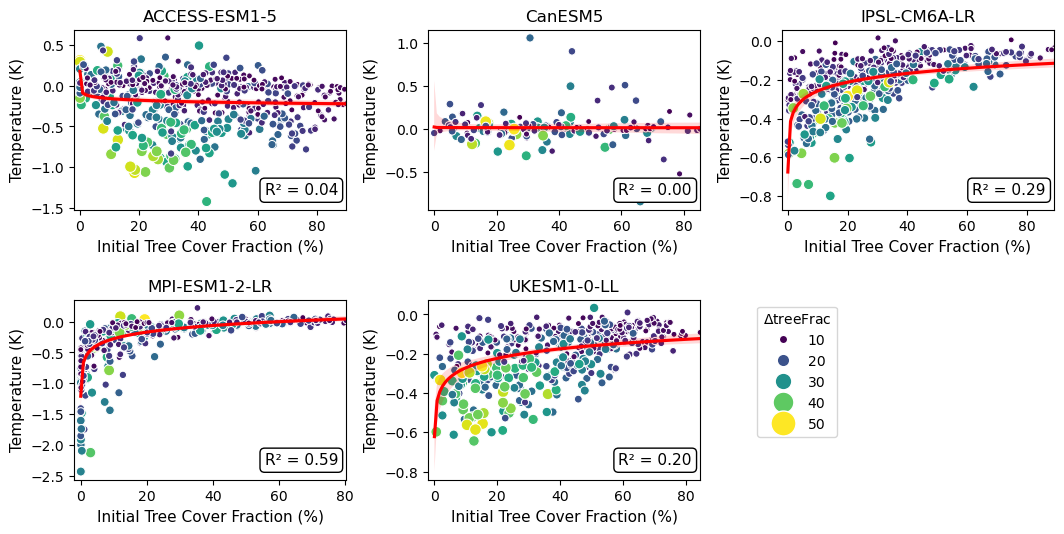

In [29]:
from statannot import add_stat_annotation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)

cmap = plt.get_cmap("viridis")
norm = mcolors.Normalize(vmin=10, vmax=50)

for m, mm in enumerate(models):

    df = ibpm_aff[ibpm_aff["models"] == mm]
    df = df[df["treeFrac_ctl"] > 0]     # Necessary to avoid zero for logarithmic fitting
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
    else:
        axs = fig.add_subplot(gs[1, m-3])

    axs = sns.scatterplot(data=df, x="treeFrac_ctl", y="AerodRes", hue='treeFrac_delta', size="treeFrac_delta", size_order=[10, 20, 30, 40, 50], palette="viridis") #, palette=['indianred', 'lightblue'])
    axs = sns.regplot(data=df, x="treeFrac_ctl", y="AerodRes", logx=True, scatter = False, ci=99, line_kws={"color": "red"})
    # Compute R² value
    X = np.log(df["treeFrac_ctl"].values).reshape(-1, 1)
    y = df["AerodRes"].values
    model = LinearRegression().fit(X, y)
    r2 = r2_score(y, model.predict(X))
        
    # Annotate R² value
    axs.annotate(f'R² = {r2:.2f}', xy=(0.7, 0.15), xycoords='axes fraction', 
                     fontsize=11, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
    
    axs.legend_.remove()
    axs.set_xlim(-2,df.treeFrac_ctl.max())
    axs.set_xlabel("Initial Tree Cover Fraction (%)", fontsize = 11)
    axs.set_ylabel("Temperature (K)", fontsize = 11)
    axs.set_title(models[m])
        
    if m == 4:
        custom_lines = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(10)), markersize=6),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(20)), markersize=9),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(30)), markersize=12),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(40)), markersize=15),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(50)), markersize=18),
        ]
        fig.legend(custom_lines, ['10', '20', '30', '40', '50'], title='$\Delta$treeFrac', loc='upper right', bbox_to_anchor=(0.65, 0.5), fontsize=10)
    
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
# fig.suptitle("Temperature effect of Aerodynamic Resistance (IBPM)", y =1.05, x = 0.45)

Text(0.45, 1.05, 'Temperature effect of Aerodynamic Resistance (IBPM)')

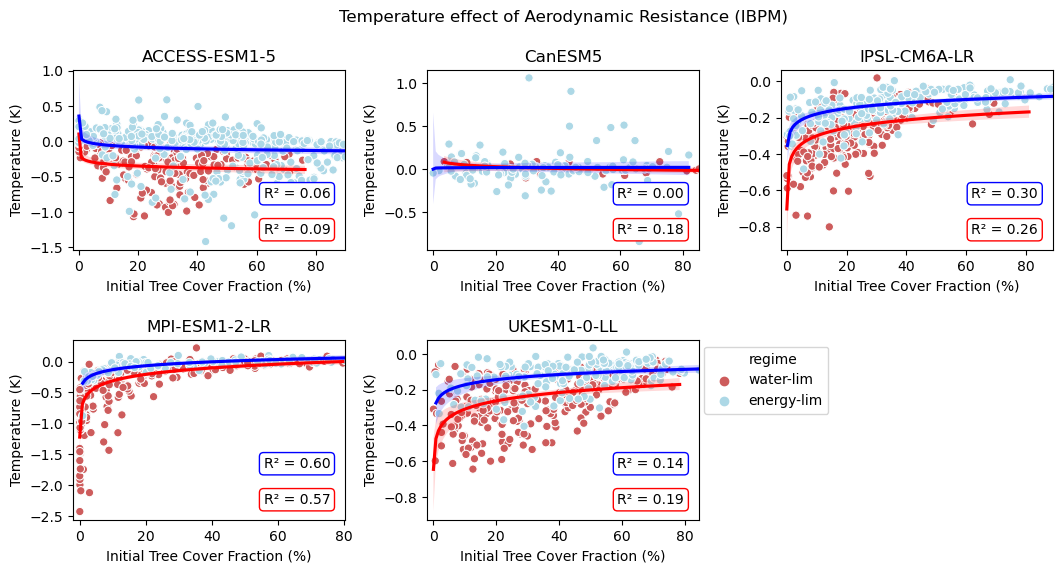

In [516]:
from statannot import add_stat_annotation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)

cmap = plt.get_cmap("viridis")
norm = mcolors.Normalize(vmin=10, vmax=50)

for m, mm in enumerate(models):

    df = ibpm_aff[ibpm_aff["models"] == mm]
    df = df[df["treeFrac_ctl"] > 0]     # Necessary to avoid zero for logarithmic fitting
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
    else:
        axs = fig.add_subplot(gs[1, m-3])

    axs = sns.scatterplot(data=df, x="treeFrac_ctl", y="AerodRes", hue='regime', palette=['indianred', 'lightblue'])
    axs = sns.regplot(data = df[df["regime"] == "water-lim"], x="treeFrac_ctl", y="AerodRes", logx=True, scatter = False, ci=99, line_kws={"color": "red"})
    axs = sns.regplot(data = df[df["regime"] == "energy-lim"], x="treeFrac_ctl", y="AerodRes", logx=True, scatter = False, ci=99, line_kws={"color": "blue"})
    # Compute R² value
    X = np.log(df[df["regime"] == "water-lim"]["treeFrac_ctl"].values).reshape(-1, 1)
    y = df[df["regime"] == "water-lim"]["AerodRes"].values
    model = LinearRegression().fit(X, y)
    r2w = r2_score(y, model.predict(X))

    # Compute R² value
    X = np.log(df[df["regime"] == "energy-lim"]["treeFrac_ctl"].values).reshape(-1, 1)
    y = df[df["regime"] == "energy-lim"]["AerodRes"].values
    model = LinearRegression().fit(X, y)
    r2e = r2_score(y, model.predict(X))
                
    # Annotate R² value
    axs.annotate(f'R² = {r2w:.2f}', xy=(0.7, 0.15), xycoords='axes fraction', 
                     fontsize=10, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="white"))
    axs.annotate(f'R² = {r2e:.2f}', xy=(0.7, 0.35), xycoords='axes fraction', 
                     fontsize=10, ha='left', va='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="blue", facecolor="white"))
        
    axs.legend_.remove()
    axs.set_xlim(-2,df.treeFrac_ctl.max())
    axs.set_xlabel("Initial Tree Cover Fraction (%)")
    axs.set_ylabel("Temperature (K)")
    axs.set_title(models[m])
        
    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)

fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
fig.suptitle("Temperature effect of Aerodynamic Resistance (IBPM)", y =1.05, x = 0.45)

#### Roughness seasonality

In [20]:
import xarray as xr
import numpy as np

# Constants (assuming these are defined somewhere in your code)
sigma = 5.67e-8  # Stefan-Boltzmann constant
rho = 1.225  # Air density in kg/m^3 (example value)
Cp = 1005  # Specific heat capacity of air at constant pressure in J/(kg·K) (example value)
eps = 0.97  # Emissivity (example value)

dT_ibpm_esm = []
dT_model_esm = []
ibpm_effect_esm_m = []

for i, mm in enumerate(models):
    # Select the time period and group by month
    xr_aff_seb = xr_aff[i].sel(time=slice("2071-01", "2100-12")).groupby("time.month").mean(dim="time")
    xr_ctl_seb = xr_ctl[i].sel(time=slice("2071-01", "2100-12")).groupby("time.month").mean(dim="time")
    
    ibpm_effects = xr.Dataset()

    lambda0 = 1 / (4 * sigma * xr_ctl_seb.tas**3)
    delta_Ta = xr_aff_seb.tas - xr_ctl_seb.tas
    gamma_ctl = (rho * Cp) * (xr_ctl_seb.ts - xr_ctl_seb.tas) / xr_ctl_seb.hfss
    gamma_aff = (rho * Cp) * (xr_aff_seb.ts - xr_aff_seb.tas) / xr_aff_seb.hfss

    Rn_aff = (xr_aff_seb.rsds - xr_aff_seb.rsus) + eps * xr_aff_seb.rlds - eps * sigma * xr_aff_seb.ts**4
    Rn_ctl = (xr_ctl_seb.rsds - xr_ctl_seb.rsus) + eps * xr_ctl_seb.rlds - eps * sigma * xr_ctl_seb.ts**4

    G_aff = Rn_aff - xr_aff_seb.hfss - xr_aff_seb.hfls
    G_ctl = Rn_ctl - xr_ctl_seb.hfss - xr_ctl_seb.hfls

    beta_ctl = xr_ctl_seb.hfss * xr_ctl_seb.hfls**-1
    beta_aff = xr_aff_seb.hfss * xr_aff_seb.hfls**-1

    delta_beta = beta_aff - beta_ctl
    delta_gamma = gamma_aff - gamma_ctl

    f = (rho * Cp) * lambda0 * gamma_ctl**-1 * (1 + 1 / beta_ctl)

    delta_Rn = Rn_aff - Rn_ctl
    delta_G = G_aff - G_ctl

    delta_f1 = -f * delta_gamma * gamma_ctl**-1
    delta_f2 = -(rho * Cp) * lambda0 * delta_beta * beta_ctl**-2

    dT_model = xr_aff_seb.ts - xr_ctl_seb.ts

    dT_ibpm = lambda0 * (1 + f)**-1 * (delta_Rn - delta_G) + -lambda0 * (1 + f)**-2 * (Rn_ctl - G_ctl) * delta_f1 + -lambda0 * (1 + f)**-2 * (Rn_ctl - G_ctl) * delta_f2 + delta_Ta

    ibpm_effects["RF"] = (lambda0 * (1 + f)**-1 * (delta_Rn - delta_G)).transpose("month", "lat", "lon")
    ibpm_effects["AerodRes"] = (-lambda0 * (1 + f)**-2 * (Rn_ctl - G_ctl) * delta_f1).transpose("month", "lat", "lon")
    ibpm_effects["BowenRatio"] = (-lambda0 * (1 + f)**-2 * (Rn_ctl - G_ctl) * delta_f2).transpose("month", "lat", "lon")
    ibpm_effects["AtmFeed"] = delta_Ta.transpose("month", "lat", "lon")
    
    dT_model_esm.append(dT_model.transpose("month", "lat", "lon"))
    dT_ibpm_esm.append(dT_ibpm.transpose("month", "lat", "lon"))
    ibpm_effect_esm_m.append(ibpm_effects)

# Convert lists to xarray Datasets
dT_model_esm = xr.concat(dT_model_esm, dim="model")
dT_ibpm_esm = xr.concat(dT_ibpm_esm, dim="model")
ibpm_effect_esm_m.append(ibpm_effects)

In [21]:
ibpm_seas = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):

    mask = mask_treefrac_pos[m].notnull() 

    masked = ibpm_effect_esm_m[m]["AerodRes"].where(mask).sel(lat = slice(-30,30))
    content = masked.weighted(cell_weight(masked)).mean(dim = ["lat","lon"])
    content = content.to_dataframe().reset_index().dropna()

    masked = ibpm_effect_esm_m[m]["AerodRes"].where(mask).sel(lat=((ibpm_effect_esm_m[m].lat >= -60) & (ibpm_effect_esm_m[m].lat < -30)) | ((ibpm_effect_esm_m[m].lat > 30) & (ibpm_effect_esm_m[m].lat <= 90)))
    content1 = masked.weighted(cell_weight(masked)).mean(dim = ["lat","lon"])
    content1 = content1.to_dataframe().reset_index().dropna()

    content["region"] = "Tropical";  content["models"] = mm
    content1["region"] = "Temperate";  content1["models"] = mm

    toclean = ["ibpm_seas", "lat", "height", "plev", "type", "time"]
    
    for c in toclean:
        if c in content.columns:
            content.drop(columns = c, inplace = True)
            content1.drop(columns = c, inplace = True)

    ibpm_seas.append(pd.concat([content, content1])); 
    
ibpm_seas = pd.concat(ibpm_seas)

c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\dask\core.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return func(*(_execute_task(a, cache) for a in args))
c:\Users\mastr\miniconda3\envs\geo_clim\lib\site-packages\das

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.45, 1.05, 'Temperature effect of Aerodynamic Resistance (IBPM)')

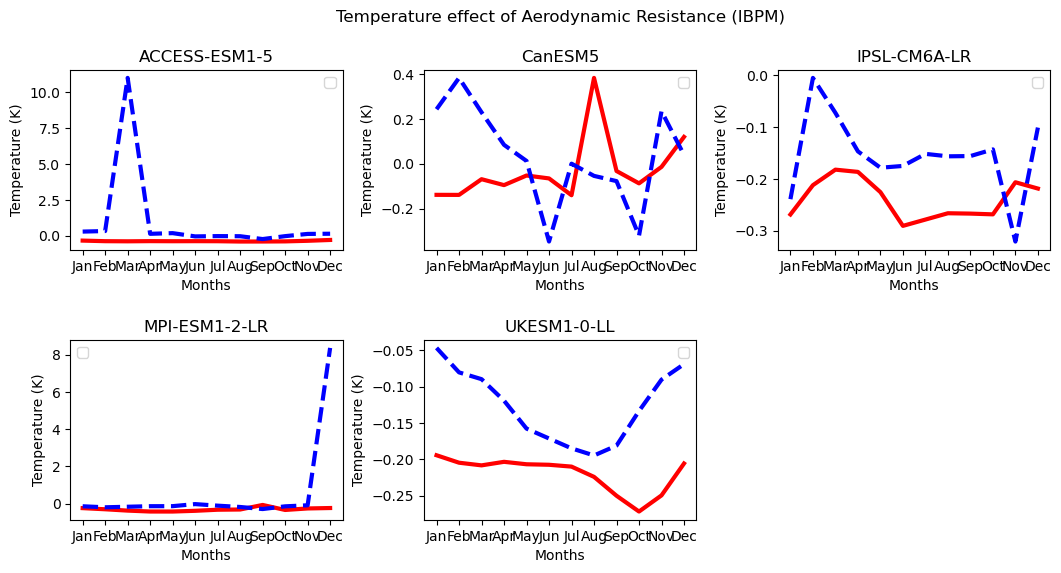

In [22]:
from statannot import add_stat_annotation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)

cmap = plt.get_cmap("viridis")
norm = mcolors.Normalize(vmin=10, vmax=50)

for m, mm in enumerate(models):

    df = ibpm_seas[ibpm_seas["models"] == mm]
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
    else:
        axs = fig.add_subplot(gs[1, m-3])

    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    axs.plot(months, df[df["region"] == "Tropical"].AerodRes, color = 'red', linewidth = 3)
    axs.plot(months, df[df["region"] == "Temperate"].AerodRes, color = 'blue', linewidth = 3, linestyle = "--")

    # axs.set_xlim(-2,df.treeFrac_ctl.max())
    axs.set_xlabel("Months")
    axs.set_ylabel("Temperature (K)")
    axs.set_title(models[m])
    axs.legend()
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
fig.suptitle("Temperature effect of Aerodynamic Resistance (IBPM)", y =1.05, x = 0.45)